In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename, j in zip(filenames, range(3)):
        print(os.path.join(dirname, filename))

/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/finaldf/finaldf.csv
/kaggle/input/dfdata/dfdata.csv
/kaggle/working/__notebook__.ipynb


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import keras
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")


Using TensorFlow backend.


In [3]:
final = pd.read_csv("/kaggle/input/dfdata/dfdata.csv").drop_duplicates(keep='first')
print(final.shape)
final.head()

(825, 24)


,day,holiday,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,...,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,housecount,TotEnergyPerDay,AvgEnergyPerDay,month,date
0,2011-11-23,0,10.36,229.0,6.29,0.36,2.04,1027.12,10.36,8.06,...,8.24,3.81,10.36,2.18,0.94,13,90.385000,6.952692,11,23
1,2011-11-24,0,12.93,204.0,8.56,0.41,4.04,1027.22,12.93,10.64,...,9.71,8.56,12.93,7.01,0.97,25,213.412000,8.536480,11,24
2,2011-11-25,0,13.03,243.0,7.24,0.48,5.02,1024.47,12.27,12.38,...,7.01,7.46,12.27,4.84,0.01,32,303.993000,9.499781,11,25
3,2011-11-26,1,12.96,237.0,6.96,0.44,5.75,1025.80,12.96,13.07,...,11.59,7.01,12.96,4.69,0.05,41,420.976000,10.267707,11,26
4,2011-11-27,1,13.54,256.0,5.76,0.42,5.48,1021.11,13.54,13.08,...,1.31,4.47,13.54,2.94,0.08,41,444.883001,10.850805,11,27


In [4]:
final.rename(columns = {"AvgEnergyPerDay":"avg_energy"}, inplace=True)

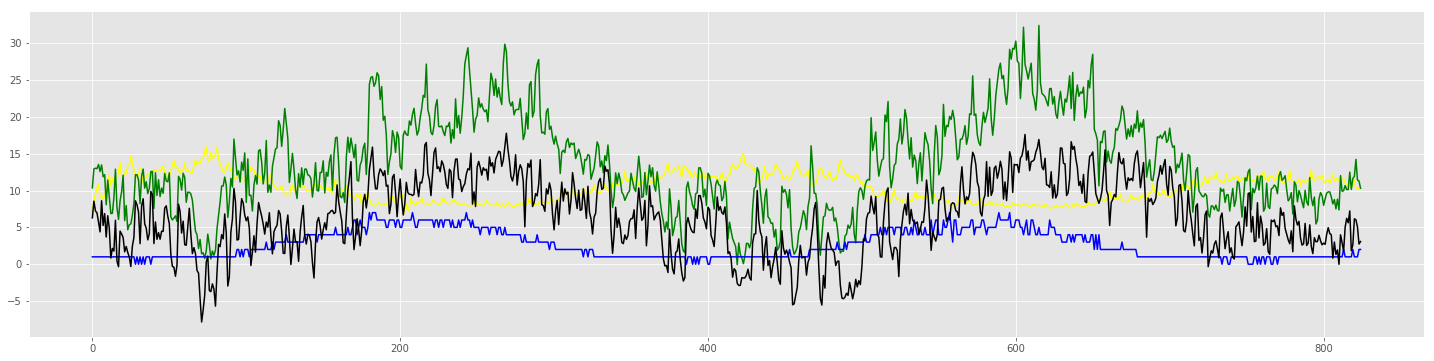

In [5]:
fig, ax1 = plt.subplots(figsize=(25, 6))
ax1.plot( final["avg_energy"], color="yellow")
ax1.plot( final["temperatureMax"],  color="green")
ax1.plot(final["uvIndex"], color="blue")
ax1.plot(final["dewPoint"], "black")
plt.show()

In [6]:
final.corr()

,holiday,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,...,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,housecount,TotEnergyPerDay,avg_energy,month,date
holiday,1.000000,-0.022552,0.008177,-0.032999,-0.038839,0.008933,0.007449,-0.023780,0.067433,-0.013283,...,-0.016115,-0.029479,-0.021151,-0.018561,0.000956,0.012312,0.055595,0.124938,0.005699,-0.022128
temperatureMax,-0.022552,1.000000,0.061190,0.865330,-0.332533,-0.154540,0.116844,0.986202,0.261225,-0.406835,...,0.882494,0.896072,0.997838,0.911201,0.007085,0.165750,-0.189267,-0.865790,0.223594,0.057496
windBearing,0.008177,0.061190,1.000000,0.090423,-0.082381,0.072214,-0.011702,0.070125,0.259234,0.021901,...,0.048638,0.062552,0.056682,0.051418,0.038114,-0.090699,-0.112187,-0.022833,0.167085,0.004163
dewPoint,-0.032999,0.865330,0.090423,1.000000,-0.025048,-0.092774,-0.028716,0.870591,0.043482,0.053107,...,0.893765,0.938765,0.862227,0.940441,-0.006186,0.178051,-0.135566,-0.771968,0.327627,0.059230
cloudCover,-0.038839,-0.332533,-0.082381,-0.025048,1.000000,0.170347,-0.097146,-0.308927,-0.332812,0.480058,...,-0.106658,-0.061194,-0.334435,-0.102108,-0.066226,0.017814,0.124058,0.251422,-0.106896,0.006600
windSpeed,0.008933,-0.154540,0.072214,-0.092774,0.170347,1.000000,-0.345830,-0.187432,0.280642,-0.040977,...,-0.072681,-0.022889,-0.162932,-0.133178,-0.022997,-0.023299,0.041965,0.145432,-0.041951,0.047952
pressure,0.007449,0.116844,-0.011702,-0.028716,-0.097146,-0.345830,1.000000,0.137121,-0.010135,-0.250061,...,0.058712,0.006228,0.128167,0.057660,0.044596,-0.221970,-0.270976,-0.027927,-0.040478,-0.004828
apparentTemperatureHigh,-0.023780,0.986202,0.070125,0.870591,-0.308927,-0.187432,0.137121,1.000000,0.232823,-0.369068,...,0.875142,0.890520,0.989487,0.913976,0.011212,0.143890,-0.210766,-0.866120,0.224258,0.059788
visibility,0.067433,0.261225,0.259234,0.043482,-0.332812,0.280642,-0.010135,0.232823,1.000000,-0.579324,...,0.171487,0.191730,0.259924,0.152172,0.061151,-0.005281,-0.115911,-0.250332,0.112126,0.001168
humidity,-0.013283,-0.406835,0.021901,0.053107,0.480058,-0.040977,-0.250061,-0.369068,-0.579324,1.000000,...,-0.171293,-0.206502,-0.411468,-0.200373,-0.015395,-0.029572,0.130125,0.372525,0.153967,-0.016646


In [7]:
final.reset_index(inplace=True)
final = final[final["day"]!="2014-02-28"]
final.tail()

,index,day,holiday,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,...,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,housecount,TotEnergyPerDay,avg_energy,month,date
820,820,2014-02-23,1,11.94,200.0,6.17,0.66,7.10,1010.37,11.94,...,7.99,8.67,11.94,5.53,0.78,4998,57379.093030,11.480411,2,23
821,821,2014-02-24,0,14.23,183.0,6.03,0.50,5.02,1005.19,14.23,...,8.25,7.99,14.23,5.52,0.82,4994,51994.546994,10.411403,2,24
822,822,2014-02-25,0,11.43,202.0,5.06,0.62,5.69,1000.65,10.31,...,4.17,6.79,10.31,3.89,0.86,4995,51423.507990,10.294997,2,25
823,823,2014-02-26,0,11.29,227.0,2.74,0.26,3.82,1012.73,11.29,...,6.01,4.17,11.29,1.67,0.90,4993,50943.305998,10.202945,2,26
824,824,2014-02-27,0,10.31,224.0,3.08,0.32,4.14,1007.02,10.31,...,3.43,3.93,10.31,1.41,0.93,4990,51678.185994,10.356350,2,27


In [8]:
final['day'] = pd.to_datetime(final["day"])
final["month"] = final["day"].dt.month
final["date"] = final["day"].dt.day

In [9]:
from sklearn import preprocessing

In [10]:
pre = preprocessing.LabelEncoder()

In [11]:
pre.fit(final["day"])

LabelEncoder()

In [12]:
final.head()

,index,day,holiday,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,...,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,housecount,TotEnergyPerDay,avg_energy,month,date
0,0,2011-11-23,0,10.36,229.0,6.29,0.36,2.04,1027.12,10.36,...,8.24,3.81,10.36,2.18,0.94,13,90.385000,6.952692,11,23
1,1,2011-11-24,0,12.93,204.0,8.56,0.41,4.04,1027.22,12.93,...,9.71,8.56,12.93,7.01,0.97,25,213.412000,8.536480,11,24
2,2,2011-11-25,0,13.03,243.0,7.24,0.48,5.02,1024.47,12.27,...,7.01,7.46,12.27,4.84,0.01,32,303.993000,9.499781,11,25
3,3,2011-11-26,1,12.96,237.0,6.96,0.44,5.75,1025.80,12.96,...,11.59,7.01,12.96,4.69,0.05,41,420.976000,10.267707,11,26
4,4,2011-11-27,1,13.54,256.0,5.76,0.42,5.48,1021.11,13.54,...,1.31,4.47,13.54,2.94,0.08,41,444.883001,10.850805,11,27


In [13]:
#pre.classes_

In [14]:
final["datetime"] = pre.transform(final["day"])

In [15]:
#final["datetime"] = [i.replace("-", "") for i in final["day"]]
#final.head()

In [16]:
print("maximum date :", max(final["day"]))
print("minimum date :", min(final["day"]))

maximum date : 2014-02-27 00:00:00
minimum date : 2011-11-23 00:00:00


In [17]:
final.columns

Index(['index', 'day', 'holiday', 'temperatureMax', 'windBearing', 'dewPoint',
       'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh',
       'visibility', 'humidity', 'apparentTemperatureLow',
       'apparentTemperatureMax', 'uvIndex', 'temperatureLow', 'temperatureMin',
       'temperatureHigh', 'apparentTemperatureMin', 'moonPhase', 'housecount',
       'TotEnergyPerDay', 'avg_energy', 'month', 'date', 'datetime'],
      dtype='object')

In [18]:
final_corr = final.corr()

# Heatmap

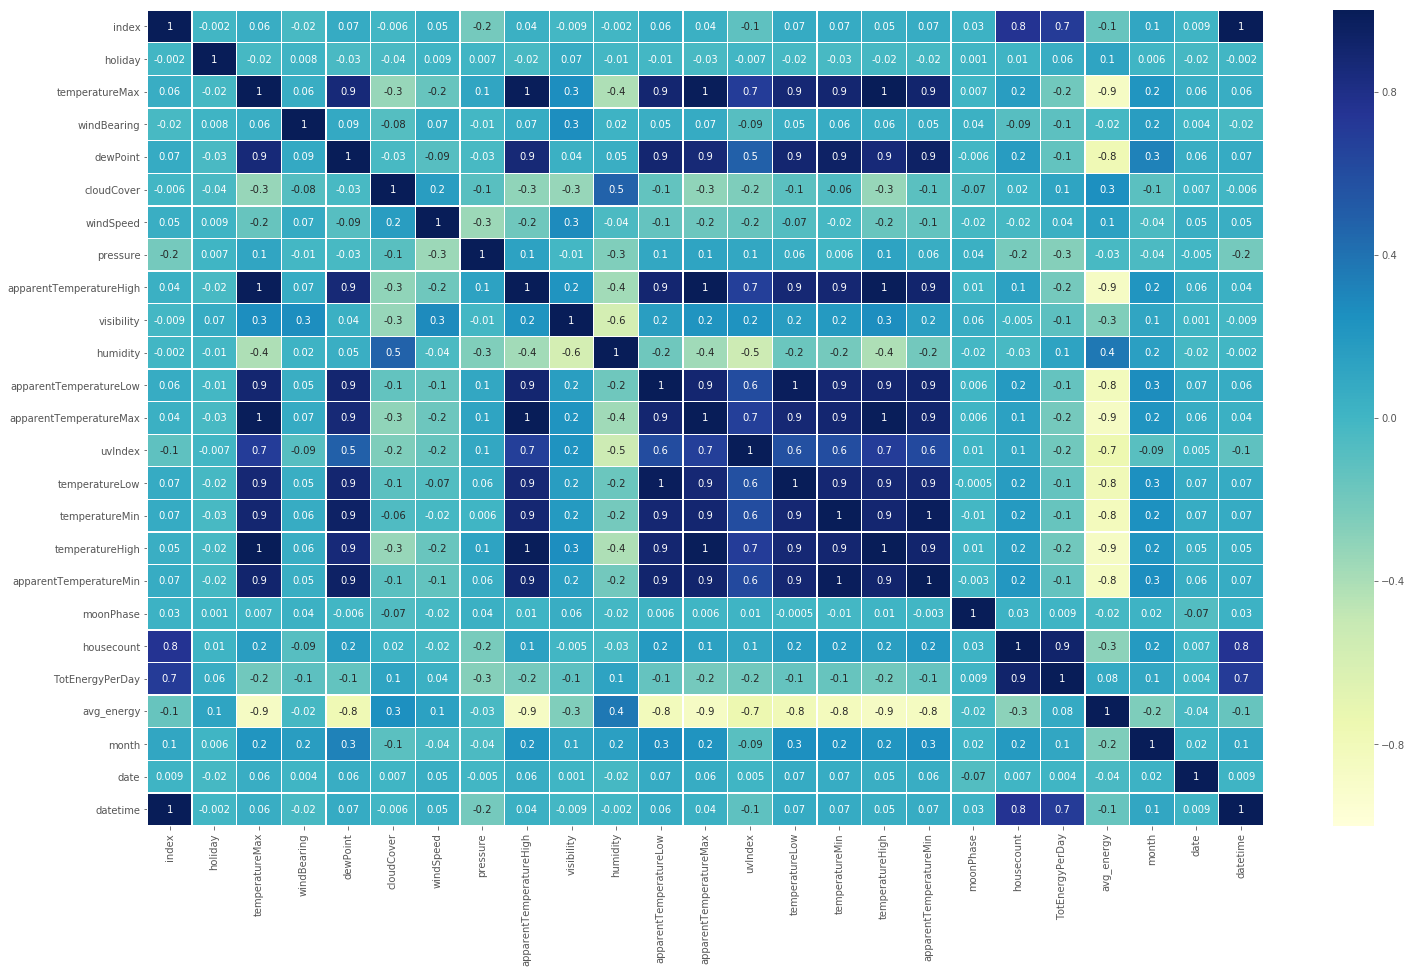

In [19]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(final_corr, cmap="YlGnBu", linewidths=0.3, annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, ax=ax)

In [20]:
final_corr.reset_index(inplace=True)

In [21]:
final_corr

,level_0,index,holiday,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,...,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,housecount,TotEnergyPerDay,avg_energy,month,date,datetime
0,index,1.000000,-0.002270,0.055565,-0.023748,0.071287,-0.005536,0.053206,-0.209055,0.039146,...,0.073798,0.049453,0.068519,0.028580,0.757468,0.708975,-0.148966,0.101824,0.009061,1.000000
1,holiday,-0.002270,1.000000,-0.022552,0.008177,-0.032999,-0.038839,0.008933,0.007449,-0.023780,...,-0.029479,-0.021151,-0.018561,0.000956,0.012312,0.055595,0.124938,0.005699,-0.022128,-0.002270
2,temperatureMax,0.055565,-0.022552,1.000000,0.061190,0.865330,-0.332533,-0.154540,0.116844,0.986202,...,0.896072,0.997838,0.911201,0.007085,0.165750,-0.189267,-0.865790,0.223594,0.057496,0.055565
3,windBearing,-0.023748,0.008177,0.061190,1.000000,0.090423,-0.082381,0.072214,-0.011702,0.070125,...,0.062552,0.056682,0.051418,0.038114,-0.090699,-0.112187,-0.022833,0.167085,0.004163,-0.023748
4,dewPoint,0.071287,-0.032999,0.865330,0.090423,1.000000,-0.025048,-0.092774,-0.028716,0.870591,...,0.938765,0.862227,0.940441,-0.006186,0.178051,-0.135566,-0.771968,0.327627,0.059230,0.071287
5,cloudCover,-0.005536,-0.038839,-0.332533,-0.082381,-0.025048,1.000000,0.170347,-0.097146,-0.308927,...,-0.061194,-0.334435,-0.102108,-0.066226,0.017814,0.124058,0.251422,-0.106896,0.006600,-0.005536
6,windSpeed,0.053206,0.008933,-0.154540,0.072214,-0.092774,0.170347,1.000000,-0.345830,-0.187432,...,-0.022889,-0.162932,-0.133178,-0.022997,-0.023299,0.041965,0.145432,-0.041951,0.047952,0.053206
7,pressure,-0.209055,0.007449,0.116844,-0.011702,-0.028716,-0.097146,-0.345830,1.000000,0.137121,...,0.006228,0.128167,0.057660,0.044596,-0.221970,-0.270976,-0.027927,-0.040478,-0.004828,-0.209055
8,apparentTemperatureHigh,0.039146,-0.023780,0.986202,0.070125,0.870591,-0.308927,-0.187432,0.137121,1.000000,...,0.890520,0.989487,0.913976,0.011212,0.143890,-0.210766,-0.866120,0.224258,0.059788,0.039146
9,visibility,-0.008956,0.067433,0.261225,0.259234,0.043482,-0.332812,0.280642,-0.010135,0.232823,...,0.191730,0.259924,0.152172,0.061151,-0.005281,-0.115911,-0.250332,0.112126,0.001168,-0.008956


# Feature Selection 

In [22]:
feature_list = [j for i, j in zip(final_corr["avg_energy"], final_corr["level_0"]) if abs(i) > 0.3]
feature_list

['temperatureMax',
 'dewPoint',
 'apparentTemperatureHigh',
 'humidity',
 'apparentTemperatureLow',
 'apparentTemperatureMax',
 'uvIndex',
 'temperatureLow',
 'temperatureMin',
 'temperatureHigh',
 'apparentTemperatureMin',
 'avg_energy']

## Save File to csv

In [23]:
final.to_csv("final.csv", index=False)

In [24]:
final_columns = ['day','temperatureMax', 'dewPoint',
       'apparentTemperatureHigh', 'temperatureMin', 'temperatureLow', 
        'temperatureHigh', #'apparentTemperatureMin',
       'uvIndex', 'month', 'datetime' , 
       'avg_energy']

In [25]:
train = final[final["day"]<"2014-02-01"][final_columns]
test = final[final["day"]>="2014-02-01"][final_columns]
#train = final[final["day"]<"2014-02-01"][["day", "temperatureMax","uvIndex", "dewPoint", "windSpeed", "pressure","humidity","housecount","month","datetime","avg_energy"]]
#test = final[final["day"]>="2014-02-01"][["day", "apparentTempetatureMax", "temperatureM","uvIndex", "dewPoint", "windSpeed", "pressure","holiday","housecount","month","datetime","avg_energy"]]
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

# Accuracy Function

In [26]:
def accuracy_function(y, y_pred):
    yhat_lower = []
    yhat_upper = []
    y_bin = [1]*len(y)
    y_pred_bin = []
    for i in y:
        yhat_lower.append(i-0.5)
        yhat_upper.append(i+0.5)
    for i, j, k in zip(yhat_lower, yhat_upper, y_pred):
        if k< j and k>i:
            y_pred_bin.append(1)
        else:
            y_pred_bin.append(0)
    acc_score = accuracy_score(y_bin, y_pred_bin)
    return acc_score

## Initiating out_df

In [27]:
out_df = pd.DataFrame()

# **Using fbprophet**

In [28]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot
from fbprophet.plot import plot_components
from sklearn.model_selection import train_test_split

In [29]:
train = pd.read_csv("/kaggle/working/train.csv")
test = pd.read_csv("/kaggle/working/test.csv")
test["day"] = pd.to_datetime(test["day"])
train["day"] = pd.to_datetime(train["day"])
train_df = train[["day", "avg_energy"]]
train_df.columns = ["ds", "y"]
test_df = test[["day", "avg_energy"]]
test_df.columns = ["ds", "y"]
test_df_ans = test_df.copy()
test_df["y"] = 0

## make model with Prophet by Facebook

In [30]:
train_df.shape, test_df.shape, test_df_ans.shape

((798, 2), (27, 2), (27, 2))

In [31]:
fb_model = Prophet()
fb_model.add_seasonality(name="monthly", period=180, fourier_order=5)
fb_model.add_country_holidays(country_name='UK')
fb_model.fit(train_df)

In [32]:
fb_model.train_holiday_names

0                                        New Year's Day
1                             New Year's Day (Observed)
2                           New Year Holiday [Scotland]
3                New Year Holiday [Scotland] (Observed)
4                  St. Patrick's Day [Northern Ireland]
5                                           Good Friday
6      Easter Monday [England, Wales, Northern Ireland]
7                                               May Day
8                                   Spring Bank Holiday
9                Battle of the Boyne [Northern Ireland]
10                       Summer Bank Holiday [Scotland]
11    Late Summer Bank Holiday [England, Wales, Nort...
12                          St. Andrew's Day [Scotland]
13                                        Christmas Day
14                             Christmas Day (Observed)
15                                           Boxing Day
16                     Wedding of William and Catherine
17    New Year Holiday [Scotland], New Year's Da

In [33]:
forecast = fb_model.predict(test_df)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-02-01,9.450818,10.864122,12.220206,9.450818,9.450818,0.0,0.0,0.0,0.0,...,0.126003,0.126003,0.126003,3.538075,3.538075,3.538075,0.0,0.0,0.0,11.562537
1,2014-02-02,9.446834,11.394020,12.645093,9.446834,9.446834,0.0,0.0,0.0,0.0,...,0.623818,0.623818,0.623818,3.664097,3.664097,3.664097,0.0,0.0,0.0,12.039831
2,2014-02-03,9.442849,10.684135,12.055035,9.442849,9.442849,0.0,0.0,0.0,0.0,...,-0.026121,-0.026121,-0.026121,3.787436,3.787436,3.787436,0.0,0.0,0.0,11.369735
3,2014-02-04,9.438865,10.594001,11.927578,9.438865,9.438865,0.0,0.0,0.0,0.0,...,-0.153754,-0.153754,-0.153754,3.907795,3.907795,3.907795,0.0,0.0,0.0,11.222637
4,2014-02-05,9.434880,10.541692,11.796570,9.434880,9.434880,0.0,0.0,0.0,0.0,...,-0.204005,-0.204005,-0.204005,4.024885,4.024885,4.024885,0.0,0.0,0.0,11.153933


In [34]:
out_df["fbprophet"] = forecast["yhat"]

In [35]:
'''def accuracy_function(y_test ,y_pred):
    y_pred_bin=[]
    for i, j, k in zip(forecast["yhat_lower"], forecast["yhat_upper"], y_pred):
        if k < j and k > i:
            y_pred_bin.append(1)
        else:
            y_pred_bin.append(0)
    
    y_test_bin=[]
    for i, j, k in zip(forecast["yhat_lower"], forecast["yhat_upper"], y_test):
        if k < j and k > i:
            y_test_bin.append(1)
        else:
            y_test_bin.append(0)
    acc_score = accuracy_score(y_test_bin, y_pred_bin)
    return acc_score'''

'def accuracy_function(y_test ,y_pred):\n    y_pred_bin=[]\n    for i, j, k in zip(forecast["yhat_lower"], forecast["yhat_upper"], y_pred):\n        if k < j and k > i:\n            y_pred_bin.append(1)\n        else:\n            y_pred_bin.append(0)\n    \n    y_test_bin=[]\n    for i, j, k in zip(forecast["yhat_lower"], forecast["yhat_upper"], y_test):\n        if k < j and k > i:\n            y_test_bin.append(1)\n        else:\n            y_test_bin.append(0)\n    acc_score = accuracy_score(y_test_bin, y_pred_bin)\n    return acc_score'

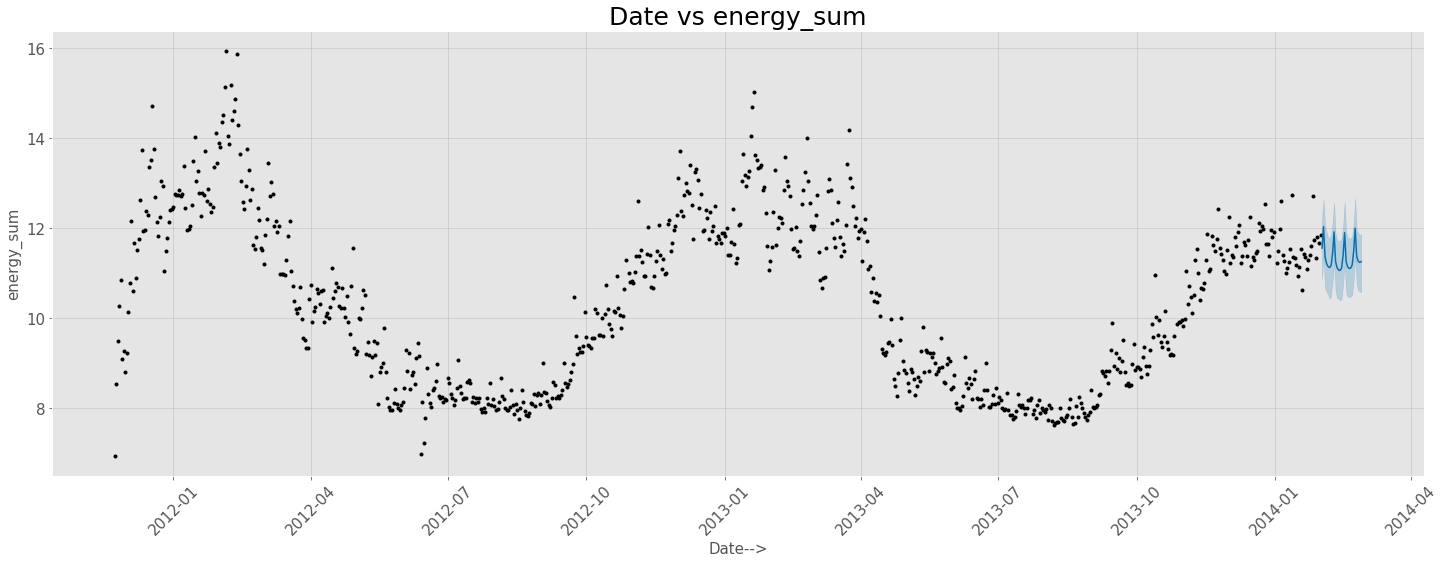

In [36]:
fig = plot(fb_model, forecast, figsize=(20, 7))
ax = fig.gca()
ax.set_title("Date vs energy_sum", size=25)
ax.set_xlabel("Date-->", size=15)
ax.set_ylabel("energy_sum", size=15)
ax.tick_params(axis="x", labelsize=15, rotation=45)
ax.tick_params(axis="y", labelsize=15)

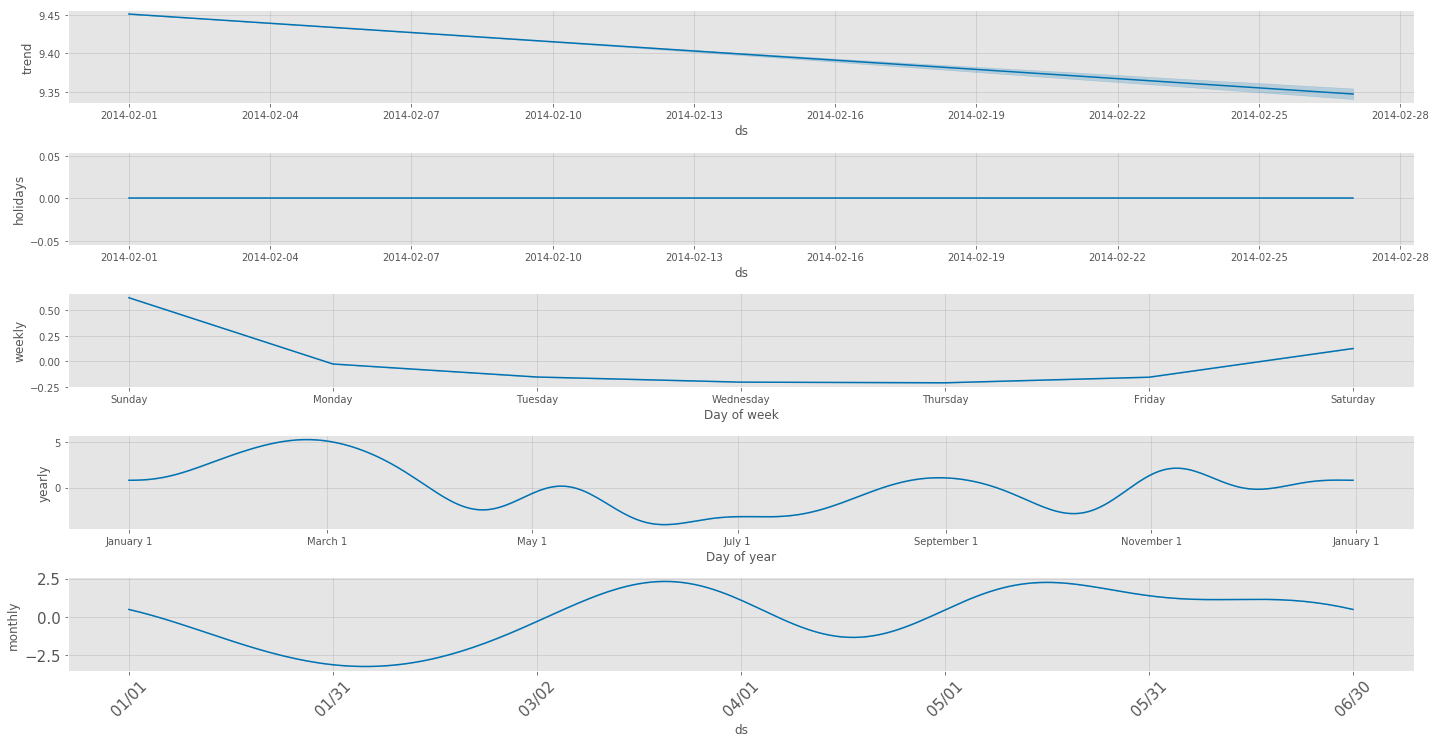

In [37]:
fig = plot_components(fb_model, forecast, figsize=(20, 10))
ax = fig.gca()
ax.tick_params(axis="x", labelsize=15, rotation=45)
ax.tick_params(axis="y", labelsize=15)

### Anlysis with cross_validation

In [38]:
df_cv = cross_validation(fb_model, horizon="60 days")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-12-08,13.157835,12.654184,13.641612,12.786987,2012-12-07
1,2012-12-09,13.757478,13.254728,14.234317,13.418991,2012-12-07
2,2012-12-10,12.935263,12.440193,13.420394,12.528336,2012-12-07
3,2012-12-11,12.695611,12.162960,13.195506,11.774059,2012-12-07
4,2012-12-12,12.474303,11.965907,12.957327,13.263261,2012-12-07


In [39]:
df_cv.shape

(776, 6)

### With performance_metrics, we can visualize the score

In [40]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,6 days,0.750297,0.866197,0.651790,0.063562,0.638362
1,7 days,1.024770,1.012309,0.760619,0.073103,0.586414
2,8 days,1.319099,1.148521,0.839557,0.080010,0.536464
3,9 days,1.628363,1.276073,0.920992,0.087624,0.487512
4,10 days,2.020264,1.421360,0.996384,0.094643,0.474525


In [41]:
forecast["ds"].shape, forecast["yhat"].shape

((27,), (27,))

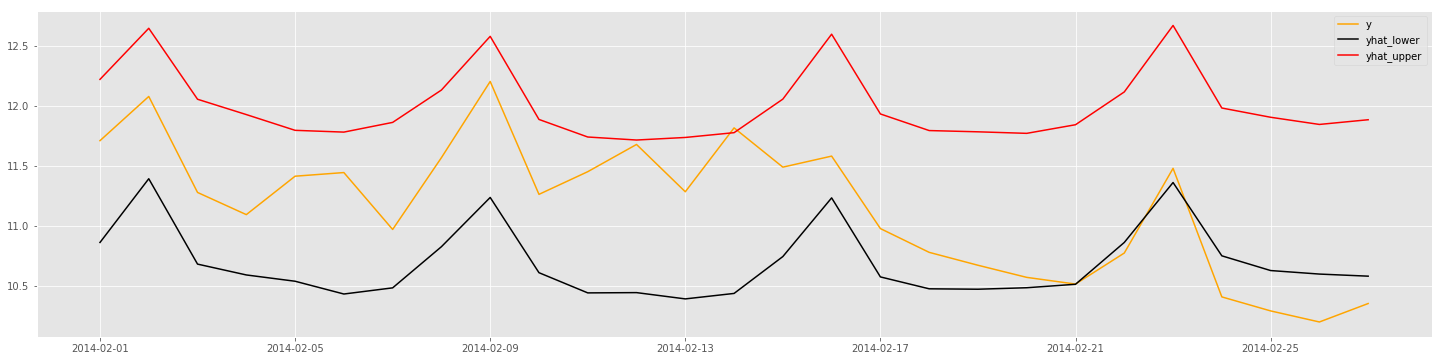

In [42]:
fig, ax1 = plt.subplots(figsize=(25, 6)) 
ax1.plot(test_df_ans["ds"], test_df_ans["y"], color="orange")
#ax1.plot(forecast["ds"], forecast["yhat"], color="blue")
ax1.plot(forecast["ds"], forecast["yhat_lower"], color="black")
ax1.plot(forecast["ds"], forecast["yhat_upper"], color="red")
ax1.legend(("y", "yhat_lower", "yhat_upper"))
# ax1.set_xlabel("days-->", fontsize=20)
# ax1.set_ylabel("energy_sum", fontsize=20)
# plt.xticks(rotation=45, fontsize=15)

## Future Prediction for next 1 year

In [43]:
future_1yr = fb_model.make_future_dataframe(periods=365)
future_1yr.tail()

,ds
1158,2015-01-27
1159,2015-01-28
1160,2015-01-29
1161,2015-01-30
1162,2015-01-31


In [44]:
forecast_1yr = fb_model.predict(future_1yr)
forecast_1yr.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-11-23,9.820708,8.844140,10.127129,9.820708,9.820708,0.0,0.0,0.0,0.0,...,-0.204005,-0.204005,-0.204005,0.575080,0.575080,0.575080,0.0,0.0,0.0,9.507914
1,2011-11-24,9.827857,8.880018,10.204197,9.827857,9.827857,0.0,0.0,0.0,0.0,...,-0.210357,-0.210357,-0.210357,0.440492,0.440492,0.440492,0.0,0.0,0.0,9.541959
2,2011-11-25,9.835005,9.038727,10.283726,9.835005,9.835005,0.0,0.0,0.0,0.0,...,-0.155584,-0.155584,-0.155584,0.315591,0.315591,0.315591,0.0,0.0,0.0,9.659246
3,2011-11-26,9.842154,9.390927,10.649450,9.842154,9.842154,0.0,0.0,0.0,0.0,...,0.126003,0.126003,0.126003,0.202133,0.202133,0.202133,0.0,0.0,0.0,10.024603
4,2011-11-27,9.849303,9.988135,11.253227,9.849303,9.849303,0.0,0.0,0.0,0.0,...,0.623818,0.623818,0.623818,0.101584,0.101584,0.101584,0.0,0.0,0.0,10.626190


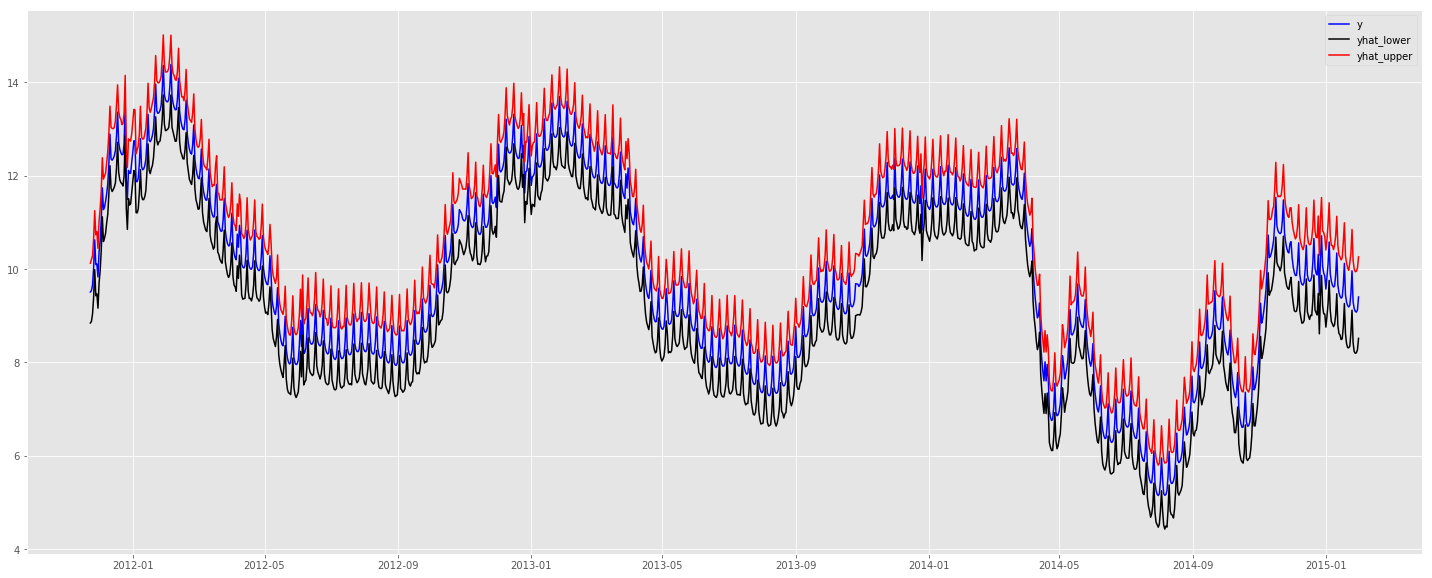

In [45]:
fig, ax1 = plt.subplots(figsize=(25, 10))
ax1.plot(forecast_1yr["ds"], forecast_1yr["yhat"], color="blue")
ax1.plot(forecast_1yr["ds"], forecast_1yr["yhat_lower"], color="black")
ax1.plot(forecast_1yr["ds"], forecast_1yr["yhat_upper"], color="red")

ax1.legend(("y", "yhat_lower", "yhat_upper"))

# Apply RNN 

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [47]:
train = pd.read_csv("/kaggle/working/train.csv")
test = pd.read_csv("/kaggle/working/test.csv")
test.head()

,day,temperatureMax,dewPoint,apparentTemperatureHigh,temperatureMin,temperatureLow,temperatureHigh,uvIndex,month,datetime,avg_energy
0,2014-02-01,9.72,3.18,4.27,4.83,6.24,8.32,1.0,2,798,11.710582
1,2014-02-02,9.30,2.63,6.48,5.79,4.97,9.30,1.0,2,799,12.078164
2,2014-02-03,7.99,2.86,4.59,4.97,4.22,7.99,1.0,2,800,11.280011
3,2014-02-04,8.88,2.69,5.63,4.22,5.54,8.88,1.0,2,801,11.095584
4,2014-02-05,9.64,4.06,5.86,5.54,7.01,9.64,1.0,2,802,11.415105


In [48]:
train.set_index("day", inplace=True)
test.set_index("day", inplace=True)

In [49]:
X_train = train.drop(["avg_energy"], axis=1).iloc[:len(train)-27,:]
X_val = train.drop("avg_energy", axis=1).iloc[len(train)-27:,:]
y_train = train["avg_energy"][:len(train)-27,]
y_val = train["avg_energy"][len(train)-27:,]
X_test = test.drop("avg_energy", axis=1)
y_test = test["avg_energy"]

In [50]:
'''scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)'''

'scaler = MinMaxScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.fit_transform(X_test)'

In [51]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((771, 9), (771,), (27, 9), (27,), (27, 9), (27,))

In [52]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
#--------------------------------------------
X_val = np.array(X_val)
y_val = np.array(y_val)

In [53]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#---------------------------------------------------------------------------------
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [54]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((771, 1, 9), (771,), (27, 1, 9), (27,))

## Normalization of X_train and X_test

In [55]:
'''X_test = tf.keras.utils.normalize(X_test, axis=1)
X_train = tf.keras.utils.normalize(X_train, axis=1)'''

'X_test = tf.keras.utils.normalize(X_test, axis=1)\nX_train = tf.keras.utils.normalize(X_train, axis=1)'

In [56]:
model = Sequential()

In [57]:
# design network

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
model.add(tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.02))
model.add(tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.05))
model.add(tf.keras.layers.Dense(10, activation="linear"))
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
es = EarlyStopping(monitor='log_loss', mode=100, verbose=4)
fit = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val))#, callbacks=[es])


SyntaxError: invalid syntax (<ipython-input-57-35451334039a>, line 5)

In [58]:
y_train_pred = model.predict(X_train)
y_train_pred_rnn = np.reshape(y_train_pred, (y_train.shape[0]))

ValueError: cannot reshape array of size 6939 into shape (771,)

NameError: name 'y_train_pred_rnn' is not defined

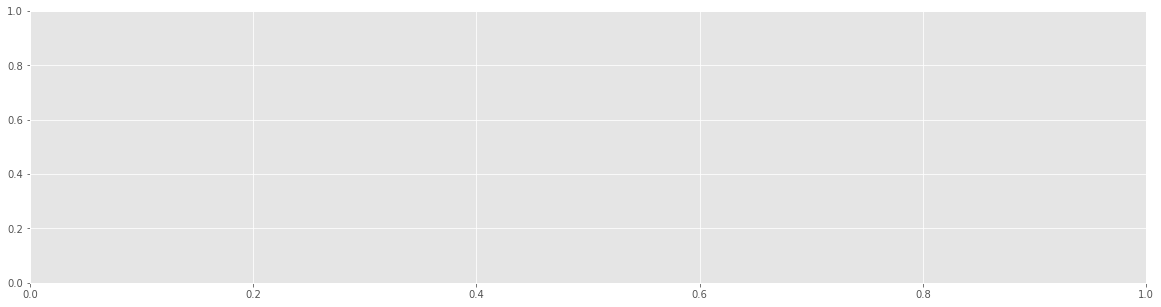

In [59]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(y_train_pred_rnn, color="blue")
ax1.plot(y_train, color="red")
ax1.legend(("y_train_pred_rnn", "y_train"))
plt.show()

In [60]:
y_test_pred = model.predict(X_test)
y_test_pred_rnn = np.reshape(y_test_pred, (y_test_pred.shape[0]))

ValueError: cannot reshape array of size 243 into shape (27,)

In [61]:
out_df["rnn"] = y_test_pred_rnn

NameError: name 'y_test_pred_rnn' is not defined

### accuracy score

In [62]:
accuracy_function(y_test, y_test_pred_rnn)

NameError: name 'y_test_pred_rnn' is not defined

NameError: name 'y_test_pred_rnn' is not defined

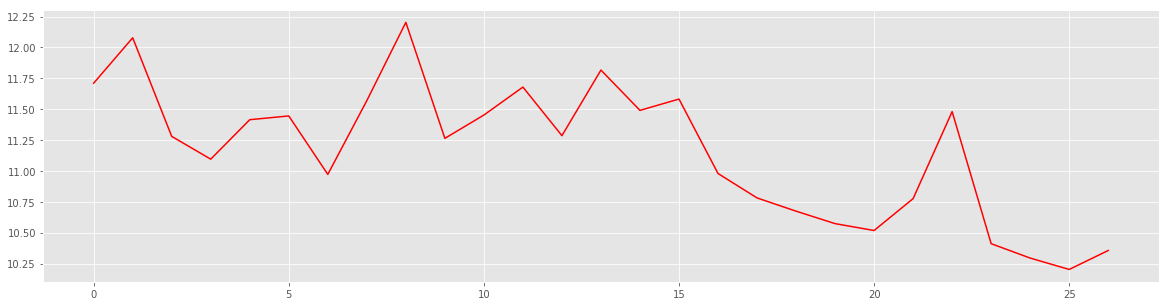

In [63]:
fig, ax2 = plt.subplots(figsize = (20,5))
ax2.plot(y_test, color="red")
ax2.plot(y_test_pred_rnn, color="blue")
ax2.legend(("y_test", "y_test_pred_rnn"))
plt.show()

### calculate root mean squared error

In [64]:
trainScore = mean_squared_error(y_train, y_train_pred_rnn)
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test, y_test_pred_rnn)
print('Test Score: %.2f MSE' % (testScore))

NameError: name 'y_train_pred_rnn' is not defined

In [65]:
trainScore = mean_absolute_error(y_train, y_train_pred_rnn)
print("trainScore : %.2f MAE" % (trainScore))
testScore = mean_absolute_error(y_test, y_test_pred_rnn)
print("testScore : %.2f MAE" % (testScore))

NameError: name 'y_train_pred_rnn' is not defined

# Using XGBOOST

In [66]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [67]:
train = pd.read_csv("/kaggle/working/train.csv")
test = pd.read_csv("/kaggle/working/test.csv")
train.head()

,day,temperatureMax,dewPoint,apparentTemperatureHigh,temperatureMin,temperatureLow,temperatureHigh,uvIndex,month,datetime,avg_energy
0,2011-11-23,10.36,6.29,10.36,3.81,8.24,10.36,1.0,11,0,6.952692
1,2011-11-24,12.93,8.56,12.93,8.56,9.71,12.93,1.0,11,1,8.536480
2,2011-11-25,13.03,7.24,12.27,7.46,7.01,12.27,1.0,11,2,9.499781
3,2011-11-26,12.96,6.96,12.96,7.01,11.59,12.96,1.0,11,3,10.267707
4,2011-11-27,13.54,5.76,13.54,4.47,1.31,13.54,1.0,11,4,10.850805


split data into X_train, y_train, X_test and y_test form

In [68]:
train.set_index("day", inplace=True)
test.set_index("day", inplace=True)
X_train = train.drop("avg_energy", axis=1)
y_train = train["avg_energy"]
X_test = test.drop("avg_energy", axis=1)
y_test = test["avg_energy"]

In [69]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((798, 9), (27, 9), (798,), (27,))

##  Instantiation of an XGBoost Regressor

In [70]:
xg_model = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.02, max_depth=3)

In [71]:

xg_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], #learning_rate = 0.01, max_depth=4,
        #early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False)

[03:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

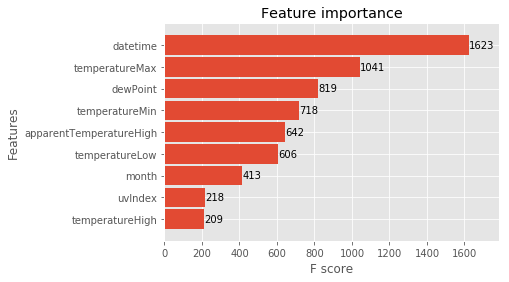

In [72]:
xgb.plot_importance(xg_model, height=0.9)

# Forecast on Test Set

In [73]:
y_train_pred_xg = xg_model.predict(X_train)

In [74]:
y_test_pred_xg = xg_model.predict(X_test)

In [75]:
out_df["xg"] = y_test_pred_xg

In [76]:
accuracy_function(y_test, y_test_pred_xg)

0.5925925925925926

## Mean squared error

In [77]:
trainScore = mean_squared_error(y_train, y_train_pred_xg)
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test, y_test_pred_xg)
print('Test Score: %.2f MSE' % (testScore))

Train Score: 0.08 MSE
Test Score: 0.23 MSE


## Mean absolute error

In [78]:
trainScore = mean_absolute_error(y_train, y_train_pred_xg)
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(y_test, y_test_pred_xg)
print('Test Score: %.2f MAE' % (testScore))

Train Score: 0.22 MAE
Test Score: 0.38 MAE


In [79]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [80]:
mean_absolute_percentage_error(y_test,y_test_pred_xg)

3.4921721075089396

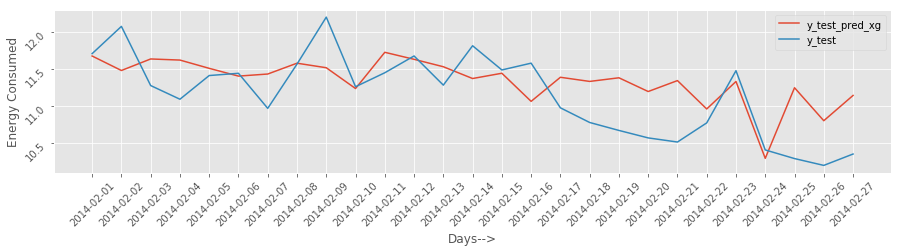

In [81]:
fig, ax1 = plt.subplots(figsize=(15,3))
ax1.plot(y_test_pred_xg, label='data')
ax1.plot(y_test, label='prediction')
ax1.set_xlabel('Days-->')
ax1.set_ylabel('Energy Consumed')
ax1.legend(("y_test_pred_xg", "y_test"))
ax1.tick_params(rotation=45)
# plt.legend()


# Gradient Boosting Regressor

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

### Instantiation of GradientBoostingRegressor

In [83]:

clf = GradientBoostingRegressor(random_state=10,learning_rate= 0.6, 
                                max_depth= 5, min_samples_leaf= 10, min_samples_split= 9, 
                                n_estimators= 50)
clf.fit(X_train,y_train)
y_train_pred_grad = clf.predict(X_train)
y_test_pred_grad = clf.predict(X_test)

In [84]:
out_df["grad"] = y_test_pred_grad

### accuracy score

In [85]:
accuracy_function(y_test, y_test_pred_grad)

0.6666666666666666

In [86]:
trainScore = mean_squared_error(y_train, y_train_pred_grad)
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test, y_test_pred_grad)
print('Test Score: %.2f MSE' % (testScore))

Train Score: 0.02 MSE
Test Score: 0.34 MSE


### Mean Absolute Error

In [87]:
trainScore = mean_absolute_error(y_train, y_train_pred_grad)
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(y_test, y_test_pred_grad)
print('Test Score: %.2f MAE' % (testScore))

Train Score: 0.11 MAE
Test Score: 0.44 MAE


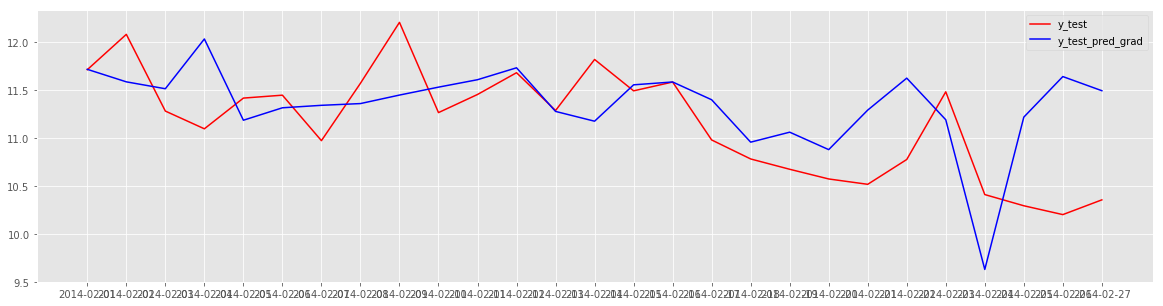

In [88]:
fig, ax2 = plt.subplots(figsize = (20,5))
ax2.plot(y_test, color="red")
ax2.plot(y_test_pred_grad, color="blue")
ax2.legend(("y_test", "y_test_pred_grad"))
plt.show()

In [89]:
'''
lr_range = np.linspace(0.1,1, 5)
n_est_range = np.arange(10,50,10)

depth_range = [3,4,5,6,7,8,9]
minsplit_range = [5,10,20,25,30]
minleaf_range = [5,10,15]

parameters = dict(learning_rate=lr_range,
                  n_estimators=n_est_range,
                  max_depth=depth_range,
                  min_samples_split=minsplit_range, 
                  min_samples_leaf=minleaf_range)

from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=2020)

from sklearn.model_selection import GridSearchCV
grad_reg = GradientBoostingRegressor(random_state=2020)
cv = GridSearchCV(grad_reg, param_grid=parameters,
                  cv=kfold,scoring='r2')

cv.fit(X_train,y_train)

print(cv.best_params_)

print(cv.best_score_)'''


"\nlr_range = np.linspace(0.1,1, 5)\nn_est_range = np.arange(10,50,10)\n\ndepth_range = [3,4,5,6,7,8,9]\nminsplit_range = [5,10,20,25,30]\nminleaf_range = [5,10,15]\n\nparameters = dict(learning_rate=lr_range,\n                  n_estimators=n_est_range,\n                  max_depth=depth_range,\n                  min_samples_split=minsplit_range, \n                  min_samples_leaf=minleaf_range)\n\nfrom sklearn.model_selection import KFold\nkfold = KFold(n_splits=5, random_state=2020)\n\nfrom sklearn.model_selection import GridSearchCV\ngrad_reg = GradientBoostingRegressor(random_state=2020)\ncv = GridSearchCV(grad_reg, param_grid=parameters,\n                  cv=kfold,scoring='r2')\n\ncv.fit(X_train,y_train)\n\nprint(cv.best_params_)\n\nprint(cv.best_score_)"

# Random Forest Tree

In [90]:
from sklearn.ensemble import RandomForestRegressor

### Instantiation of Random Forest Regressor

In [91]:
ran_reg = RandomForestRegressor(random_state=2020)
ran_reg.fit(X_train, y_train)
y_test_pred_ran = ran_reg.predict(X_test)
y_train_pred_ran = ran_reg.predict(X_train)

In [92]:
y_test.shape

(27,)

### accuracy score

In [93]:
accuracy_function(y_test, y_test_pred_ran)

0.5925925925925926

In [94]:
trainScore = mean_squared_error(y_train, y_train_pred_ran)
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test, y_test_pred_ran)
print('Test Score: %.2f MSE' % (testScore))

Train Score: 0.05 MSE
Test Score: 0.30 MSE


### Mean Absolute Error

In [95]:
trainScore = mean_absolute_error(y_train, y_train_pred_ran)
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(y_test, y_test_pred_ran)
print('Test Score: %.2f MAE' % (testScore))

Train Score: 0.15 MAE
Test Score: 0.46 MAE


In [96]:
out_df["random"] = y_test_pred_ran

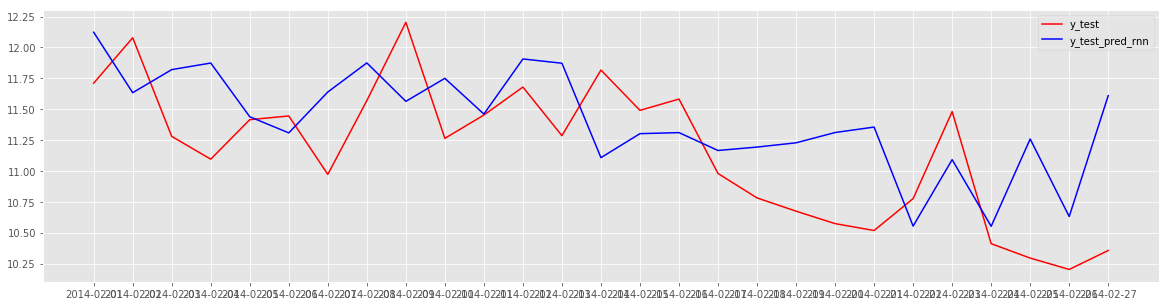

In [97]:
fig, ax2 = plt.subplots(figsize = (20,5))
ax2.plot(y_test, color="red")
ax2.plot(y_test_pred_ran, color="blue")
ax2.legend(("y_test", "y_test_pred_rnn"))
plt.show()

# Linear Regression

In [98]:
from sklearn.linear_model import LinearRegression

In [99]:
train = pd.read_csv("/kaggle/working/train.csv")
test = pd.read_csv("/kaggle/working/test.csv")
train.head()

,day,temperatureMax,dewPoint,apparentTemperatureHigh,temperatureMin,temperatureLow,temperatureHigh,uvIndex,month,datetime,avg_energy
0,2011-11-23,10.36,6.29,10.36,3.81,8.24,10.36,1.0,11,0,6.952692
1,2011-11-24,12.93,8.56,12.93,8.56,9.71,12.93,1.0,11,1,8.536480
2,2011-11-25,13.03,7.24,12.27,7.46,7.01,12.27,1.0,11,2,9.499781
3,2011-11-26,12.96,6.96,12.96,7.01,11.59,12.96,1.0,11,3,10.267707
4,2011-11-27,13.54,5.76,13.54,4.47,1.31,13.54,1.0,11,4,10.850805


In [100]:
X_train = train.drop(["avg_energy", "day"], axis=1)
y_train = train["avg_energy"]
X_test = test.drop(["avg_energy", "day"], axis=1)
y_test = test["avg_energy"]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((798, 9), (798,), (27, 9), (27,))

### Instantiation of LinearRegression

In [101]:
lin_reg = LinearRegression(normalize=0.2)
lin_reg.fit(X_train, y_train)
y_train_pred_reg = lin_reg.predict(X_train)
y_test_pred_reg = lin_reg.predict(X_test)

In [102]:
out_df["linear"] = y_test_pred_reg

### accuracy score

In [103]:
accuracy_function(y_test, y_test_pred_reg)

0.5185185185185185

### Mean Squared Error

In [104]:
trainScore = mean_squared_error(y_train, y_train_pred_reg)
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test, y_test_pred_reg)
print('Test Score: %.2f MSE' % (testScore))

Train Score: 0.52 MSE
Test Score: 0.29 MSE


### Mean Absolute Error

In [105]:
trainScore = mean_absolute_error(y_train, y_train_pred_reg)
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_absolute_error(y_test, y_test_pred_reg)
print('Test Score: %.2f MSE' % (testScore))

Train Score: 0.55 MSE
Test Score: 0.48 MSE


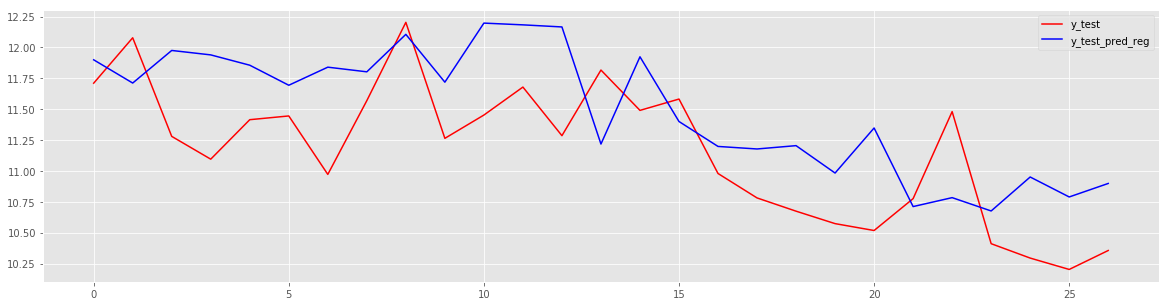

In [106]:
fig, ax2 = plt.subplots(figsize = (20,5))
ax2.plot(y_test, color="red")
ax2.plot(y_test_pred_reg, color="blue")
ax2.legend(("y_test", "y_test_pred_reg"))
plt.show()

# SUPPORT VECTOR MACHINE

In [107]:
from sklearn.svm import SVR

### Instantiation of Support Vector Regressor

In [108]:
svm_reg = SVR()
svm_reg.fit(X_train, y_train)
y_train_pred_svm = svm_reg.predict(X_train)
y_test_pred_svm = svm_reg.predict(X_test)

In [109]:
out_df["svm"] = y_test_pred_svm

### accuracy score

In [110]:
accuracy_function(y_test, y_test_pred_svm)

0.25925925925925924

### Mean Squared Error

In [111]:
trainScore = mean_squared_error(y_train, y_train_pred_svm)
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test, y_test_pred_svm)
print('Test Score: %.2f MSE' % (testScore))

Train Score: 0.71 MSE
Test Score: 1.12 MSE


### Mean Absolute Error

In [112]:
trainScore = mean_absolute_error(y_train, y_train_pred_svm)
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(y_test, y_test_pred_svm)
print('Test Score: %.2f MAE' % (testScore))

Train Score: 0.56 MAE
Test Score: 0.91 MAE


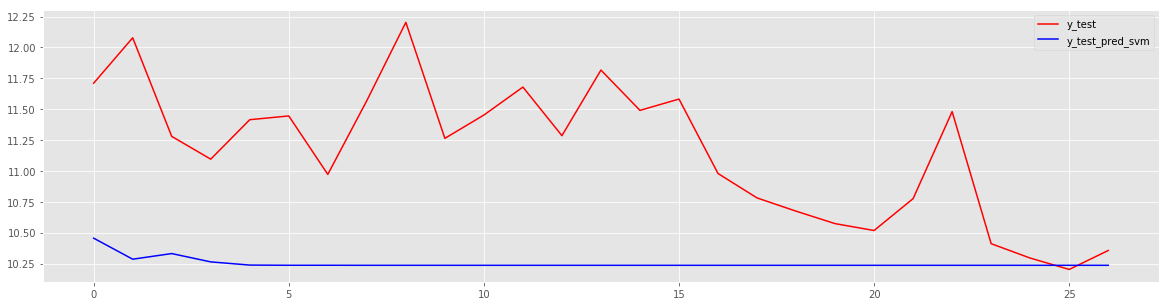

In [113]:
fig, ax2 = plt.subplots(figsize = (20,5))
ax2.plot(y_test, color="red")
ax2.plot(y_test_pred_svm, color="blue")
ax2.legend(("y_test", "y_test_pred_svm"))
plt.show()

# SARIMAX

In [114]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 9.1MB/s 
Note: you may need to restart the kernel to use updated packages.


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
from sklearn.metrics import r2_score
import statsmodels.api as sm
from pmdarima.arima import auto_arima

In [116]:
#train = pd.read_csv("/kaggle/working/train.csv")
#test = pd.read_csv("/kaggle/working/test.csv")
final = pd.read_csv("/kaggle/working/final.csv")

In [117]:
#train.head()
sari_columns = ['temperatureMax', 'dewPoint',#'weather_cluster',
       
       'temperatureMin',
       'uvIndex', 'temperatureLow', 
       'temperatureHigh', 
       'avg_energy']#, 'month', 'datetime']

In [118]:
final.head()

,index,day,holiday,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,...,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,housecount,TotEnergyPerDay,avg_energy,month,date,datetime
0,0,2011-11-23,0,10.36,229.0,6.29,0.36,2.04,1027.12,10.36,...,3.81,10.36,2.18,0.94,13,90.385000,6.952692,11,23,0
1,1,2011-11-24,0,12.93,204.0,8.56,0.41,4.04,1027.22,12.93,...,8.56,12.93,7.01,0.97,25,213.412000,8.536480,11,24,1
2,2,2011-11-25,0,13.03,243.0,7.24,0.48,5.02,1024.47,12.27,...,7.46,12.27,4.84,0.01,32,303.993000,9.499781,11,25,2
3,3,2011-11-26,1,12.96,237.0,6.96,0.44,5.75,1025.80,12.96,...,7.01,12.96,4.69,0.05,41,420.976000,10.267707,11,26,3
4,4,2011-11-27,1,13.54,256.0,5.76,0.42,5.48,1021.11,13.54,...,4.47,13.54,2.94,0.08,41,444.883001,10.850805,11,27,4


In [119]:
final.columns

Index(['index', 'day', 'holiday', 'temperatureMax', 'windBearing', 'dewPoint',
       'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh',
       'visibility', 'humidity', 'apparentTemperatureLow',
       'apparentTemperatureMax', 'uvIndex', 'temperatureLow', 'temperatureMin',
       'temperatureHigh', 'apparentTemperatureMin', 'moonPhase', 'housecount',
       'TotEnergyPerDay', 'avg_energy', 'month', 'date', 'datetime'],
      dtype='object')

In [120]:
# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train)
# train_scaled_df = pd.DataFrame(train_scaled)
# train_scaled_df.head()

# Dickey Fuller's Test

ADF-test(Original-time-series)

For Average Energy Per Day

When Original-data is not stationary and Differenced-data is stationary,the time series is called unit root process.

For unit root process, we use ARIMA or SARIMA model. From results, we decided that Original time series is not stationary

H0 : Data is not stationary H1 : Data is stationary

If p is greater than 0.05 then data is not stationary

What is adfuller method parameter 'regression'?

’c’ : constant only (default) ’ct’ : constant and trend ’ctt’ : constant, and linear and quadratic trend ’nc’ : no constant, no trend

ADF-test(differenced-time-series)


In [121]:
t = sm.tsa.adfuller(final["avg_energy"], autolag='AIC',regression='ct')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.950460
p-value                          0.628139
#Lags Used                      21.000000
Number of Observations Used    803.000000
dtype: float64

In [122]:
final["day"] = pd.to_datetime(final["day"])
final.set_index("day", inplace=True)
final_sample = final.resample("W").mean()
final_sample.head()

,index,holiday,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,...,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,housecount,TotEnergyPerDay,avg_energy,month,date,datetime
day,,,,,,,,,,,,,,,,,,,,,
2011-11-27,2.0,0.400000,12.564000,233.800000,6.962000,0.422000,4.466000,1025.144000,12.412000,11.446000,...,6.262000,12.412000,4.332000,0.410000,30.400000,294.729800,9.221493,11.000000,25.000000,2.0
2011-12-04,8.0,0.285714,11.238571,223.714286,5.752857,0.465714,4.078571,1010.838571,10.167143,12.508571,...,5.067143,10.807143,2.790000,0.217143,86.571429,877.449143,9.929826,11.571429,13.857143,8.0
2011-12-11,15.0,0.285714,8.291429,242.285714,2.185714,0.320000,5.300000,1009.545714,5.360000,12.801429,...,2.721429,8.291429,-0.922857,0.431429,166.142857,1989.198000,11.834351,12.000000,8.000000,15.0
2011-12-18,22.0,0.285714,7.330000,257.857143,2.008571,0.410000,4.707143,999.557143,2.805714,12.318571,...,2.475714,6.594286,-1.271429,0.662857,249.428571,3235.645572,12.889940,12.000000,15.000000,22.0
2011-12-25,29.0,0.285714,10.117143,253.285714,5.790000,0.570000,4.182857,1020.912857,8.721429,12.175714,...,5.135714,9.980000,1.947143,0.777143,355.571429,4500.322001,12.677327,12.000000,22.000000,29.0


In [123]:
t = sm.tsa.adfuller(final_sample["avg_energy"], autolag='AIC',regression='ct')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -4.686941
p-value                          0.000735
#Lags Used                      11.000000
Number of Observations Used    107.000000
dtype: float64

Data is not stationary so apply resampling of train dataset

test dataset is stationary

In [124]:
final_sample.shape

(119, 25)

In [125]:
train = final_sample[sari_columns][:(len(final_sample)-7)]
test = final_sample[sari_columns][len(final_sample)-7:]

In [126]:
len(train), len(test)

(112, 7)

# Seasonal Decompose
We use statsmodel for seasonal decompose as an additive model and the frequency of the time series which is the periodicity of the data which is 365 days for an yearly data.
Additive model = Trend + Seasonality + Random Noise

We can use an additive model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 100 units of energy production). A multiplicative model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of energy production everyyear).

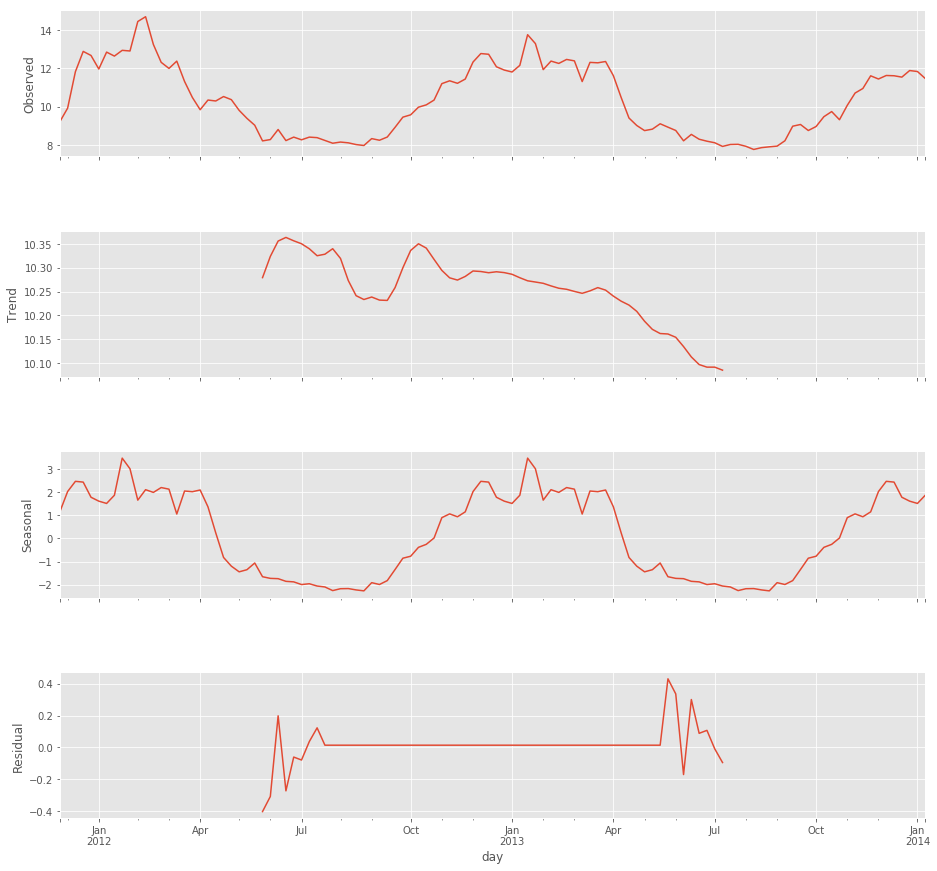

In [127]:
seas_d=sm.tsa.seasonal_decompose(train['avg_energy'],model="additive",freq=52)
fig=seas_d.plot()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()

In [128]:
X_train=train.drop("avg_energy", axis=1)
y_train=train["avg_energy"]
X_test=test.drop("avg_energy", axis=1)
y_test=test["avg_energy"]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112, 6), (7, 6), (112,), (7,))

In [129]:
model = auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1, max_p=3, max_q=3, m=52,
                    seasonal=True,trace=True, error_action='ignore', suppress_warnings=True,
                    stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 52); AIC=112.837, BIC=134.514, Fit time=0.090 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 52); AIC=116.814, BIC=143.909, Fit time=11.350 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 52); AIC=111.092, BIC=130.059, Fit time=0.138 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 52); AIC=114.829, BIC=139.215, Fit time=9.317 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 52); AIC=114.819, BIC=139.204, Fit time=0.242 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 52); AIC=114.824, BIC=139.209, Fi

In [130]:
model.aic()

111.09182952960653

In [131]:
model_order = model.order
model_seasonal_order = model.seasonal_order
#model_order = (0, 1, 1)
#model_seasonal_order = (0, 0, 0, 52)

In [132]:
model_sarimax = sm.tsa.statespace.SARIMAX(endog = y_train,order=model_order,
                                          seasonal_order=model_seasonal_order, 
                                          exog = X_train,enforce_stationarity=False, 
                                          enforce_invertibility=False)

In [133]:
model_fit = model_sarimax.fit()

In [134]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             avg_energy   No. Observations:                  112
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -47.748
Date:                Wed, 12 Feb 2020   AIC                            109.496
Time:                        03:57:23   BIC                            128.399
Sample:                    11-27-2011   HQIC                           117.163
                         - 01-12-2014                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
temperatureMax     -0.1044      0.155     -0.674      0.500      -0.408       0.199
dewPoint           -0.0311      0.043     -0.725      0.468      -0.115       0.053
temperatureMin     -0.1324      0.063     -2.096      0.036      -0.256      -0.009
uvIndex            -0.1380      0.150     -0.921      0.357      -0.432       0.156
temperatureLow      0.0839      0.058      1.445      0.149      -0.030       0.198
temperatureHigh     0.0186      0.143      0.130      0.897      -0.263       0.300
sigma2              0.1395      0.015      9.096      0.000       0.109       0.170
===================================================================================
Ljung-Box (Q):                       33.12   Jarque-Bera (JB):                19.55
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
print(max(X_test.index))
print(min(X_test.index))

2014-03-02 00:00:00
2014-01-19 00:00:00


In [136]:
print(max(X_train.index.date))
print(min(X_train.index.date))

2014-01-12
2011-11-27


In [137]:
y_train_pred_sarimax = model_fit.predict(start=min(X_train.index.date), end=max(X_train.index.date),exog = X_train)
y_train_pred_sarimax.head()

day
2011-11-27    -1.629750
2011-12-04     9.433305
2011-12-11    10.325122
2011-12-18    11.881319
2011-12-25    12.682776
Freq: W-SUN, dtype: float64

In [138]:
y_test_pred_sarimax = model_fit.predict(start=min(X_test.index.date), end=max(X_test.index.date),exog = X_test)
y_test_pred_sarimax.head()

2014-01-19    11.456521
2014-01-26    11.702441
2014-02-02    11.789390
2014-02-09    11.611054
2014-02-16    11.711541
Freq: W-SUN, dtype: float64

In [139]:
forecast=model_fit.forecast(steps='2014-03-02', exog=X_test)

## r2 score for train and test dataset

In [140]:
r2_score(y_train, y_train_pred_sarimax)

0.642362564416227

In [141]:
r2_score(y_test, y_test_pred_sarimax)

0.14404157595240863

## Mean Squared Error

In [142]:
trainScore = mean_squared_error(y_train, y_train_pred_sarimax)
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test, y_test_pred_sarimax)
print('Test Score: %.2f MSE' % (testScore))

Train Score: 1.19 MSE
Test Score: 0.18 MSE


In [143]:
trainScore = mean_absolute_error(y_train, y_train_pred_sarimax)
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(y_test, y_test_pred_sarimax)
print('Test Score: %.2f MAE' % (testScore))

Train Score: 0.37 MAE
Test Score: 0.33 MAE


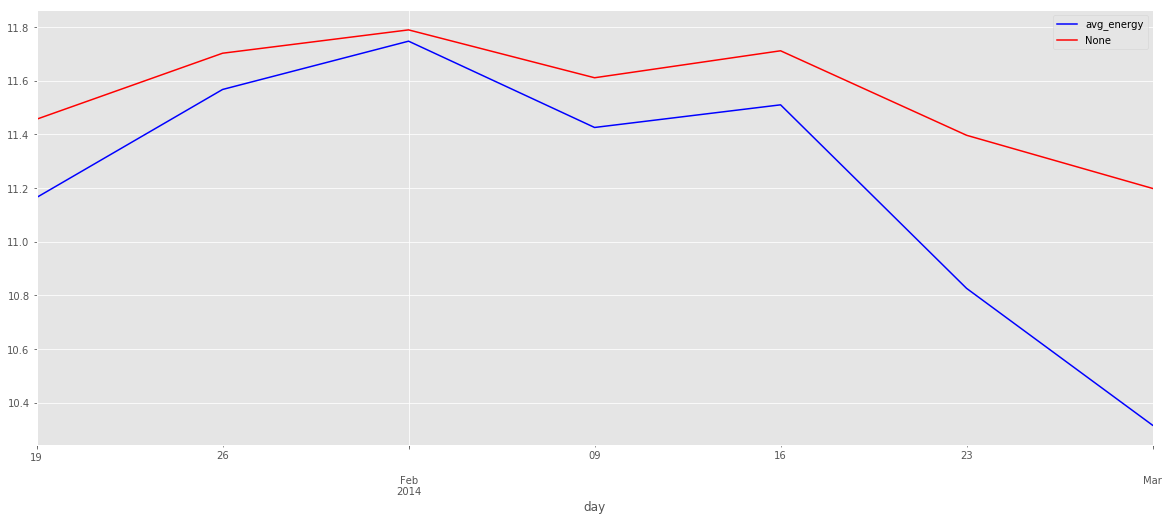

In [144]:
y_test.plot(figsize=(20,8), legend=True, color='blue')
y_test_pred_sarimax.plot(legend=True, color='red', figsize=(20,8))

# MEAN OF ALL OUTPUT

In [145]:
out_df.head()

,fbprophet,xg,grad,random,linear,svm
0,11.562537,11.678476,11.714278,12.122976,11.899753,10.455939
1,12.039831,11.483238,11.584115,11.633532,11.711742,10.285953
2,11.369735,11.638743,11.512353,11.820417,11.975480,10.331465
3,11.222637,11.623839,12.030109,11.873605,11.939624,10.264121
4,11.153933,11.512259,11.184743,11.438878,11.856082,10.238300


In [146]:
#out_df.drop("svm", axis=1, inplace=True)
#out_df.head()

In [147]:
def final_output(df):
    
    y_out_pred = df.mean(axis=1)
    
    return y_out_pred

y_out_pred = final_output(out_df)
y_out_pred.head()

0    11.572327
1    11.456402
2    11.441366
3    11.492323
4    11.230699
dtype: float64

In [148]:
test = pd.read_csv("/kaggle/working/test.csv")
y_test = test["avg_energy"]

In [149]:
y_test.shape, y_out_pred.shape

((27,), (27,))

In [150]:
r2_score(y_test, y_out_pred)

0.4205050179528148

In [151]:
accuracy_function(y_test, y_out_pred)

0.7407407407407407

### Mean Squared Error

In [152]:
testScore = mean_squared_error(y_test, y_out_pred)
print('Test Score: %.2f MSE' % (testScore))

Test Score: 0.17 MSE


### Mean Absolute Error

In [153]:
testScore = mean_absolute_error(y_test, y_out_pred)
print('Test Score: %.2f MSE' % (testScore))

Test Score: 0.34 MSE


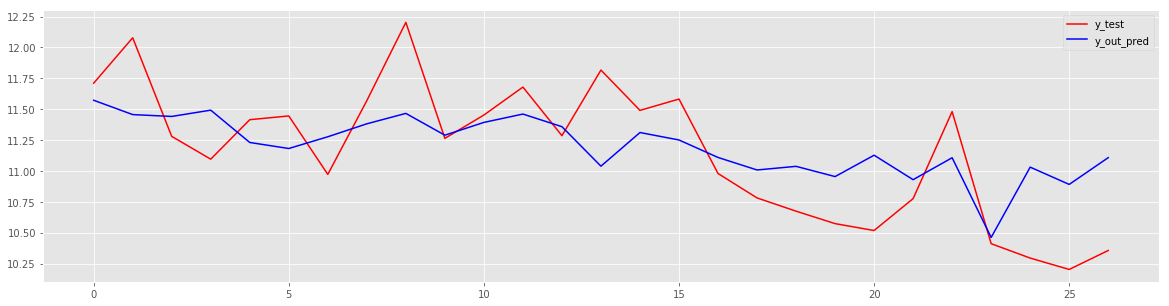

In [154]:
fig, ax2 = plt.subplots(figsize = (20,5))
ax2.plot(y_test, color="red")
ax2.plot(y_out_pred, color="blue")
ax2.legend(("y_test", "y_out_pred"))
plt.show()